In [6]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'browser'

In [7]:
# Time series analysis - Medicaid enrollments

# Load the data
df = pd.read_csv('data/final/merged_county_data.csv')

# Extract Medicaid MA enrollment columns (2022_07 through 2023_06)
ma_columns = ['2022_07', '2022_08', '2022_09', '2022_10', '2022_11', '2022_12',
              '2023_01', '2023_02', '2023_03', '2023_04', '2023_05', '2023_06']

# Extract Medicare MC enrollment columns (reverse order in dataset: Jun-23 to Jul-22)
mc_columns = ['Jun-23', 'May-23', 'Apr-23', 'Mar-23', 'Feb-23', 'Jan-23',
              'Dec-22', 'Nov-22', 'Oct-22', 'Sep-22', 'Aug-22', 'Jul-22']

# Create dates for x-axis
dates = pd.date_range(start='2022-07-01', periods=12, freq='MS')

In [8]:
# Interactive Time Series: Top Counties by Average Enrollment
df['Total_Avg_Enrollment'] = df['AVG_MA_Enrollments_2023_FY'] + df['AVG_MC_Enrollees']
top_counties = df.nlargest(10, 'Total_Avg_Enrollment')

fig1 = go.Figure()

# Add Medicaid traces for top counties
for idx, row in top_counties.iterrows():
    ma_values = row[ma_columns].values
    fig1.add_trace(go.Scatter(
        x=dates,
        y=ma_values,
        mode='lines+markers',
        name=f"{row['County']} - Medicaid",
        line=dict(width=2),
        hovertemplate='<b>%{fullData.name}</b><br>' +
                      'Date: %{x|%b %Y}<br>' +
                      'Enrollments: %{y:,.0f}<br>' +
                      '<extra></extra>'
    ))

fig1.update_layout(
    title='Medicaid (MA) Enrollment Trends - Top 10 Counties by Total Enrollment',
    xaxis_title='Month',
    yaxis_title='Number of Enrollments',
    hovermode='closest',
    template='plotly_white',
    height=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig1.show()

In [9]:
# Animated Regional Time Series
fig2 = go.Figure()

regions = df['Region'].unique()
colors = px.colors.qualitative.Set2

for i, region in enumerate(regions):
    region_data = df[df['Region'] == region]
    ma_totals = region_data[ma_columns].sum()
    
    fig2.add_trace(go.Scatter(
        x=dates,
        y=ma_totals.values,
        mode='lines+markers',
        name=region,
        line=dict(width=3, color=colors[i % len(colors)]),
        marker=dict(size=8),
        hovertemplate='<b>%{fullData.name}</b><br>' +
                      'Date: %{x|%b %Y}<br>' +
                      'Total Enrollments: %{y:,.0f}<br>' +
                      '<extra></extra>'
    ))

fig2.update_layout(
    title='Medicaid Enrollment Trends by Region',
    xaxis_title='Month',
    yaxis_title='Total Regional Enrollments',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    showlegend=True
)

fig2.show()

In [10]:
# Medicare vs Medicaid Comparison
fig3 = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Medicaid (MA) vs Medicare (MC) - Statewide Totals', 
                    'Growth Rate Comparison'),
    vertical_spacing=0.12
)

# Calculate statewide totals
medicaid_totals = df[ma_columns].sum()
medicare_totals = df[mc_columns[::-1]].sum()  # Reverse to match chronological order

fig3.add_trace(go.Scatter(
    x=dates, y=medicaid_totals.values,
    mode='lines+markers',
    name='Medicaid (MA)',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=8)
), row=1, col=1)

fig3.add_trace(go.Scatter(
    x=dates, y=medicare_totals.values,
    mode='lines+markers',
    name='Medicare (MC)',
    line=dict(color='#ff7f0e', width=3),
    marker=dict(size=8)
), row=1, col=1)

# Calculate month-over-month growth rates
medicaid_growth = medicaid_totals.pct_change() * 100
medicare_growth = medicare_totals.pct_change() * 100

fig3.add_trace(go.Scatter(
    x=dates[1:], y=medicaid_growth.values[1:],
    mode='lines+markers',
    name='Medicaid Growth %',
    line=dict(color='#1f77b4', width=2),
    showlegend=False
), row=2, col=1)

fig3.add_trace(go.Scatter(
    x=dates[1:], y=medicare_growth.values[1:],
    mode='lines+markers',
    name='Medicare Growth %',
    line=dict(color='#ff7f0e', width=2),
    showlegend=False
), row=2, col=1)

fig3.update_xaxes(title_text="Month", row=2, col=1)
fig3.update_yaxes(title_text="Total Enrollments", row=1, col=1)
fig3.update_yaxes(title_text="Growth Rate (%)", row=2, col=1)

fig3.update_layout(
    height=800,
    template='plotly_white',
    hovermode='x unified'
)

fig3.show()

In [11]:
# ED Visits by Payer Type
payer_columns = [col for col in df.columns if col.startswith('Payer_') and 
                 col not in ['Payer_Total_Number_of_Visits', 'Payer_Patient_Residence_State_NC',
                            'Payer_SC', 'Payer_TN']]

# Calculate statewide totals for each payer type
payer_totals = {}
for col in payer_columns:
    payer_name = col.replace('Payer_', '').replace('_', ' ')
    total = df[col].sum()
    if total > 0 and 'Patient Disposition' not in payer_name:
        payer_totals[payer_name] = total

# Sort by value
payer_totals = dict(sorted(payer_totals.items(), key=lambda x: x[1], reverse=True))

fig4 = go.Figure(data=[
    go.Bar(
        x=list(payer_totals.values()),
        y=list(payer_totals.keys()),
        orientation='h',
        marker=dict(
            color=list(payer_totals.values()),
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Visits")
        ),
        hovertemplate='<b>%{y}</b><br>' +
                      'Total Visits: %{x:,.0f}<br>' +
                      '<extra></extra>'
    )
])

fig4.update_layout(
    title='Emergency Department Visits by Payer Type (Statewide)',
    xaxis_title='Number of Visits',
    yaxis_title='Payer Type',
    template='plotly_white',
    height=700,
    yaxis=dict(autorange="reversed")
)

fig4.show()

In [12]:
# ED Visits by County - Top 15
ed_total_col = 'Total_ED'
top_ed_counties = df.nlargest(15, ed_total_col)[['County', 'Region', ed_total_col, 'E_TOTPOP']]
top_ed_counties['ED_per_1000'] = (top_ed_counties[ed_total_col] / top_ed_counties['E_TOTPOP']) * 1000

fig5 = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Total ED Visits', 'ED Visits per 1,000 Population'),
    specs=[[{"type": "bar"}, {"type": "bar"}]]
)

fig5.add_trace(go.Bar(
    x=top_ed_counties['County'],
    y=top_ed_counties[ed_total_col],
    marker_color='indianred',
    name='Total Visits',
    hovertemplate='<b>%{x}</b><br>' +
                  'Total ED Visits: %{y:,.0f}<br>' +
                  '<extra></extra>'
), row=1, col=1)

fig5.add_trace(go.Bar(
    x=top_ed_counties['County'],
    y=top_ed_counties['ED_per_1000'],
    marker_color='lightseagreen',
    name='Per 1,000 Pop',
    hovertemplate='<b>%{x}</b><br>' +
                  'ED Visits per 1,000: %{y:.1f}<br>' +
                  '<extra></extra>'
), row=1, col=2)

fig5.update_xaxes(tickangle=-45)
fig5.update_layout(
    title_text='Emergency Department Utilization - Top 15 Counties',
    template='plotly_white',
    height=600,
    showlegend=False
)

fig5.show()

In [13]:
# Point of Origin Analysis
origin_columns = [col for col in df.columns if col.startswith('Point_of_Origin_')]
origin_totals = {}

for col in origin_columns:
    origin_name = col.replace('Point_of_Origin_', '').replace('_', ' ')
    total = df[col].sum()
    if total > 0:
        origin_totals[origin_name] = total

fig6 = go.Figure(data=[go.Pie(
    labels=list(origin_totals.keys()),
    values=list(origin_totals.values()),
    hole=0.4,
    hovertemplate='<b>%{label}</b><br>' +
                  'Visits: %{value:,.0f}<br>' +
                  'Percentage: %{percent}<br>' +
                  '<extra></extra>'
)])

fig6.update_layout(
    title='Emergency Department Visits by Point of Origin',
    template='plotly_white',
    height=600
)

fig6.show()

In [14]:
# Race/Ethnicity Breakdown
race_columns = ['Race_African_American', 'Race_American_Indian', 
                'Race_Asian/Pacific_Islander', 'Race_Caucasian', 'Race_Other_Race']
race_totals = {}

for col in race_columns:
    if col in df.columns:
        race_name = col.replace('Race_', '').replace('_', ' ')
        total = df[col].sum()
        if total > 0:
            race_totals[race_name] = total

fig7 = go.Figure(data=[go.Bar(
    x=list(race_totals.keys()),
    y=list(race_totals.values()),
    marker=dict(
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
    ),
    hovertemplate='<b>%{x}</b><br>' +
                  'ED Visits: %{y:,.0f}<br>' +
                  '<extra></extra>'
)])

fig7.update_layout(
    title='Emergency Department Visits by Race/Ethnicity',
    xaxis_title='Race/Ethnicity',
    yaxis_title='Number of Visits',
    template='plotly_white',
    height=600
)

fig7.show()

LINEAR MODEL

Ridge Regression
  R²:   0.8871
  RMSE: 12910.2876

POLYNOMIAL MODELS

Polynomial Ridge (degree=2)
  R²:   0.8558
  RMSE: 14592.8214

TREE-BASED MODELS

Random Forest
  R²:   0.8562
  RMSE: 14570.2224

Gradient Boosting
  R²:   0.8655
  RMSE: 14090.0160

SUPPORT VECTOR MACHINES

SVR with linear kernel
  R²:   0.8617
  RMSE: 14289.2140

K-NEAREST NEIGHBORS

K-Nearest Neighbors
  R²:   0.5811
  RMSE: 24867.7831

NEURAL NETWORK

Neural Network
  R²:   0.6628
  RMSE: 22312.1616

SUMMARY COMPARISON
             Model       R²         RMSE
             Ridge 0.887109 12910.287575
 Gradient Boosting 0.865534 14090.015998
      SVR (linear) 0.861705 14289.213988
     Random Forest 0.856213 14570.222377
Poly Ridge (deg=2) 0.855766 14592.821364
    Neural Network 0.662812 22312.161642
               KNN 0.581146 24867.783061


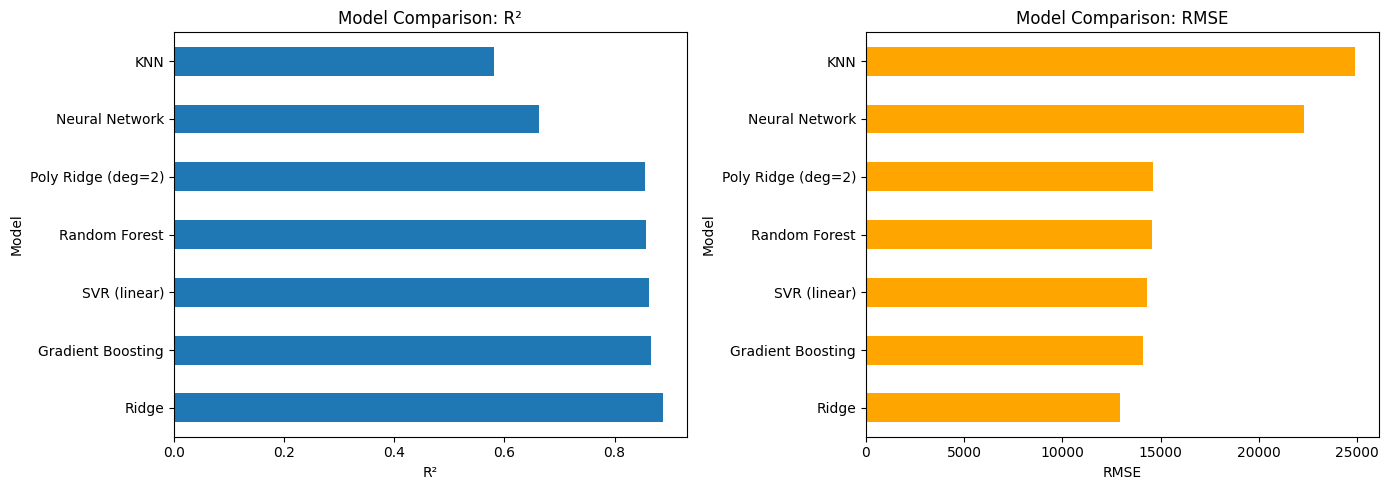


Best model: Ridge


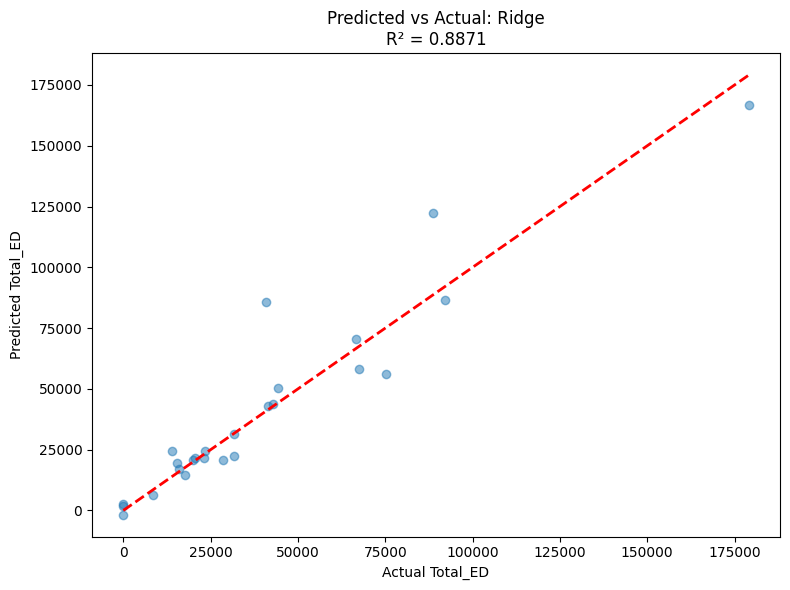


FEATURE IMPORTANCE (Random Forest)


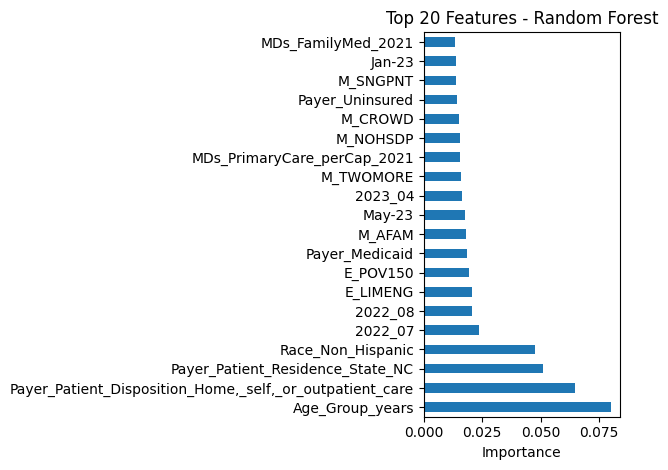

In [15]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
df = pd.read_csv("data/final/merged_county_data.csv")
y = df["Total_ED"].astype(float)
X = df.drop(columns=["County","Region","Total_ED"]).apply(pd.to_numeric, errors="coerce").fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Dictionary to store results
results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """Train model and return R² and RMSE"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n{name}")
    print(f"  R²:   {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    
    return {"R²": r2, "RMSE": rmse, "predictions": y_pred}

# Ridge Regression (baseline - linear)
print("="*50)
print("LINEAR MODEL")
print("="*50)

ridge = Pipeline([
    ("scale", StandardScaler()),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 50)))
])
results["Ridge"] = evaluate_model("Ridge Regression", ridge, X_train, X_test, y_train, y_test)

# Polynomial Ridge (smooth non-linearity)
print("\n" + "="*50)
print("POLYNOMIAL MODELS")
print("="*50)

poly_ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 50)))
])
results["Poly Ridge (deg=2)"] = evaluate_model("Polynomial Ridge (degree=2)", 
                                                poly_ridge, X_train, X_test, y_train, y_test)

# Tree-based models
print("\n" + "="*50)
print("TREE-BASED MODELS")
print("="*50)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
results["Random Forest"] = evaluate_model("Random Forest", rf, X_train, X_test, y_train, y_test)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.01, random_state=42)
results["Gradient Boosting"] = evaluate_model("Gradient Boosting", gb, X_train, X_test, y_train, y_test)

# Support Vector Regression
print("\n" + "="*50)
print("SUPPORT VECTOR MACHINES")
print("="*50)

svr = Pipeline([
    ("scale", StandardScaler()), 
    ("model", SVR(
        kernel='linear',       
        C=100,              
        gamma='scale',     
        epsilon=0.1,       
        cache_size=1000,    
        max_iter=-1        
    ))
])
results["SVR (linear)"] = evaluate_model("SVR with linear kernel", svr, X_train, X_test, y_train, y_test)

# K-Nearest Neighbors
print("\n" + "="*50)
print("K-NEAREST NEIGHBORS")
print("="*50)

knn = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=10, weights='distance'))
])
results["KNN"] = evaluate_model("K-Nearest Neighbors", knn, X_train, X_test, y_train, y_test)

# Neural Network
print("\n" + "="*50)
print("NEURAL NETWORK")
print("="*50)

mlp = Pipeline([
    ("scale", StandardScaler()),
    ("model", MLPRegressor(
        hidden_layer_sizes=(100, 50, 25),  
        activation='relu',                  
        solver='adam',                     
        alpha=0.01,                        
        batch_size='auto',                 
        learning_rate='adaptive',          
        learning_rate_init=0.001,         
        max_iter=2000,                     
        early_stopping=True,               
        validation_fraction=0.1,         
        n_iter_no_change=50,              
        random_state=42,
        verbose=False
    ))
])
results["Neural Network"] = evaluate_model("Neural Network", mlp, X_train, X_test, y_train, y_test)

# Summary comparison
print("\n" + "="*50)
print("SUMMARY COMPARISON")
print("="*50)

# Create comparison dataframe
comparison = pd.DataFrame({
    "Model": list(results.keys()),
    "R²": [results[m]["R²"] for m in results.keys()],
    "RMSE": [results[m]["RMSE"] for m in results.keys()]
})
comparison = comparison.sort_values("R²", ascending=False).reset_index(drop=True)
print(comparison.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
comparison.plot(x="Model", y="R²", kind="barh", ax=axes[0], legend=False)
axes[0].set_xlabel("R²")
axes[0].set_title("Model Comparison: R²")
axes[0].axvline(x=0, color='k', linestyle='-', linewidth=0.5)

# RMSE comparison
comparison.plot(x="Model", y="RMSE", kind="barh", ax=axes[1], legend=False, color='orange')
axes[1].set_xlabel("RMSE")
axes[1].set_title("Model Comparison: RMSE")

plt.tight_layout()
plt.show()

# Predicted vs Actual for best model
best_model = comparison.iloc[0]["Model"]
print(f"\nBest model: {best_model}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, results[best_model]["predictions"], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Total_ED")
plt.ylabel("Predicted Total_ED")
plt.title(f"Predicted vs Actual: {best_model}\nR² = {results[best_model]['R²']:.4f}")
plt.tight_layout()
plt.show()

# Feature importance for tree-based models
if isinstance(rf.named_steps['model'] if isinstance(rf, Pipeline) else rf, 
              (RandomForestRegressor, GradientBoostingRegressor)):
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE (Random Forest)")
    print("="*50)
    
    feature_imp = pd.Series(rf.feature_importances_, index=X.columns)
    feature_imp.sort_values(ascending=False).head(20).plot(kind="barh")
    plt.title("Top 20 Features - Random Forest")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()